In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

In [2]:
df = pd.read_csv('./data/ks-projects-201801.csv')
print("Shape:", df.shape)
df.head()

Shape: (378661, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [3]:
# stateのユニーク
y = df.state
y.unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [4]:
y.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

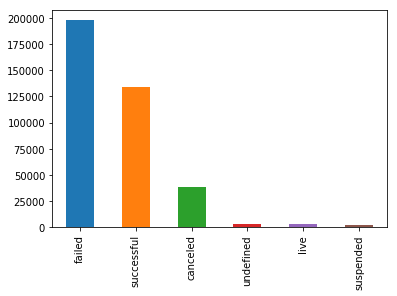

In [5]:
y.value_counts().plot.bar()

In [6]:
# successful=> True / other=> False
y_bool = y =='successful'
y_bool.head()

0    False
1    False
2    False
3    False
4    False
Name: state, dtype: bool

In [7]:
df.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

## 数字を抽出

In [8]:
df_num = df.select_dtypes(include=['float64','int64'])
df_num.head()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,1000.0,0.0,0,0.0,0.0,1533.95
1,1000003930,30000.0,2421.0,15,100.0,2421.0,30000.00
2,1000004038,45000.0,220.0,3,220.0,220.0,45000.00
3,1000007540,5000.0,1.0,1,1.0,1.0,5000.00
4,1000011046,19500.0,1283.0,14,1283.0,1283.0,19500.00


In [9]:
X = df_num.drop(['ID','usd_pledged_real', 'backers'], axis=1)
X.head()

,goal,pledged,usd pledged,usd_goal_real
0,1000.0,0.0,0.0,1533.95
1,30000.0,2421.0,100.0,30000.00
2,45000.0,220.0,220.0,45000.00
3,5000.0,1.0,1.0,5000.00
4,19500.0,1283.0,1283.0,19500.00


## 数字以外を抽出

In [10]:
df_obj = df.select_dtypes(include=['O'])
df_obj.head()

,name,category,main_category,currency,deadline,launched,state,country
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,GB
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,US
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,US
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,US
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,US


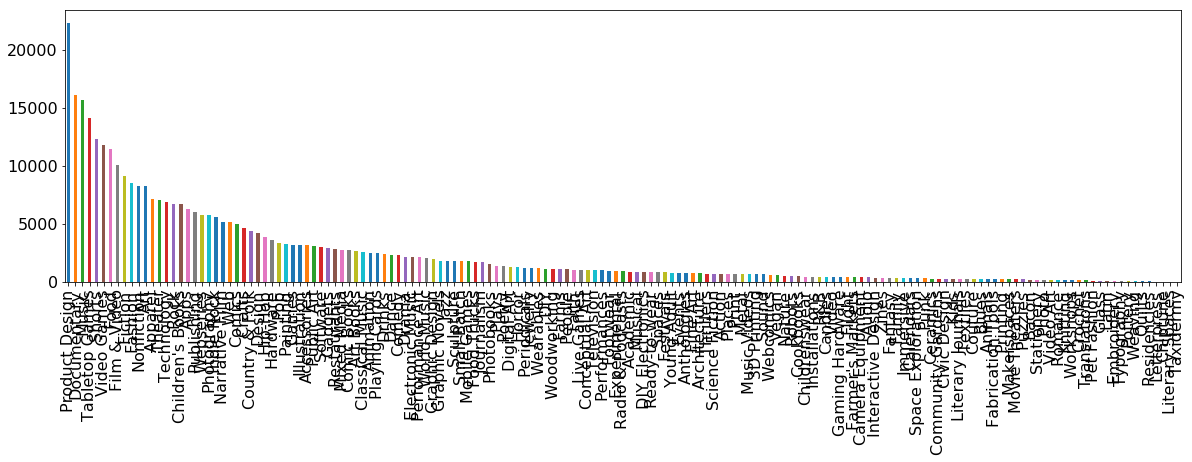

In [11]:
df_obj.category.value_counts().plot(kind='bar', figsize=(20,5), fontsize=16)

In [12]:
col_name = ['category', 'main_category', 'currency', 'country']
col_date = ['deadline', 'launched']

In [13]:
# テキストを数字に変換
df_cat = pd.DataFrame()
for name in col_name:
    df_cat[name] = df_obj[name].astype('category').cat.codes

In [14]:
df_cat.head()

,category,main_category,currency,country
0,108,12,5,9
1,93,6,13,22
2,93,6,13,22
3,90,10,13,22
4,55,6,13,22


In [15]:
# launchとdeadlineをdatetimeにする
df_date = pd.DataFrame()
for name in col_date:
    df_date[name] = pd.to_datetime(df_obj[name])

In [16]:
# launchからdeadlineまでの日数を特徴量にする
df_days = df_date[col_date[0]] - df_date[col_date[1]]
df_days.head()

0   58 days 11:47:32
1   59 days 19:16:03
2   44 days 23:39:10
3   29 days 20:35:49
4   55 days 15:24:57
dtype: timedelta64[ns]

In [17]:
df_cat['days'] = df_days.astype('timedelta64[D]')

In [18]:
df_cat.head()

,category,main_category,currency,country,days
0,108,12,5,9,58.0
1,93,6,13,22,59.0
2,93,6,13,22,44.0
3,90,10,13,22,29.0
4,55,6,13,22,55.0


In [42]:
X = df_cat.values
print('X:{} y:{}'.format(X.shape, y_bool.shape))
train_x, train_y = X[:], y_bool[:]
print('X:{} y:{}'.format(train_x.shape, train_y.shape))

X:(378661, 5) y:(378661,)
X:(378661, 5) y:(378661,)


In [ ]:
# ロジスティック回帰
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=0)
clf.fit(train_x, train_y)

In [ ]:
y_est = clf.predict(train_x)

print('train_y:{}, y_est:{}'.format(train_y.shape, y_est.shape))
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(train_y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(train_y, y_est)))

In [ ]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(train_y, y_est), 
                        index=['正解 = 成功', '正解 = 不成功'], 
                        columns=['予測 = 成功', '予測 = 不成功'])
conf_mat